# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [72]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

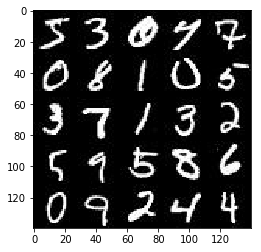

In [73]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

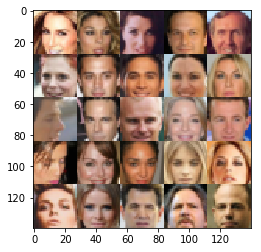

In [74]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [75]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/Users/Pierre/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [78]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape = [None, image_width,image_height,image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape = [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Users/Pierre/anaconda/envs/dlnd-tf-lab/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Users/Pierre/anaconda/envs/dlnd-tf-lab/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Users/Pierre/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/Users/Pierre/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Users/Pierre/anaconda/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [79]:
def discriminator(images, reuse=False,alpha = 0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Conv 1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        # Conv 2
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x128
        
        # Conv 3
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        # Logit
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=0.5)
        out = tf.sigmoid(logits)
    
    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [80]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
       
    with tf.variable_scope('generator', reuse=not (is_train)):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)      
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [81]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Generator
    g_model = generator(input_z, out_channel_dim, is_train=True,alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    # Discriminator
    d_loss_real_labels=tf.ones_like(d_logits_real)*0.9 
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_loss_real_labels))
    
    # Losses
    d_loss_fake_labels=tf.zeros_like(d_logits_fake)
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_loss_fake_labels))
    
    g_loss_labels=tf.ones_like(d_model_fake)
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_loss_labels))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [64]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [82]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess!: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [84]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z,lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7592... Generator Loss: 1.5895
Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 3.5784
Epoch 1/2... Discriminator Loss: 2.6570... Generator Loss: 5.1436
Epoch 1/2... Discriminator Loss: 1.0026... Generator Loss: 1.5654
Epoch 1/2... Discriminator Loss: 2.4670... Generator Loss: 0.1891
Epoch 1/2... Discriminator Loss: 1.1433... Generator Loss: 1.5382
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 1.0580
Epoch 1/2... Discriminator Loss: 1.6991... Generator Loss: 2.4931
Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 1.3776
Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.6822


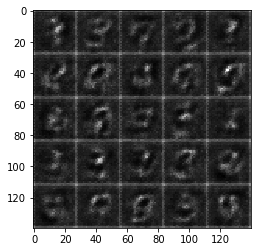

Epoch 1/2... Discriminator Loss: 1.1783... Generator Loss: 0.7582
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.8023
Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 1.0767
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.9082
Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 1.3927
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.1951
Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 2.0447
Epoch 1/2... Discriminator Loss: 0.9153... Generator Loss: 1.3339
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 0.8800... Generator Loss: 1.5981


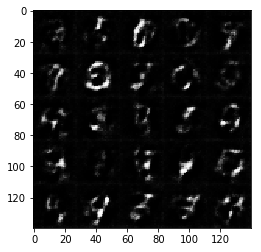

Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 1.3754
Epoch 1/2... Discriminator Loss: 0.9792... Generator Loss: 0.9816
Epoch 1/2... Discriminator Loss: 0.8674... Generator Loss: 1.1517
Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 1.1115
Epoch 1/2... Discriminator Loss: 0.7516... Generator Loss: 1.3653
Epoch 1/2... Discriminator Loss: 0.8400... Generator Loss: 1.1865
Epoch 1/2... Discriminator Loss: 0.7364... Generator Loss: 1.5034
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.7322
Epoch 1/2... Discriminator Loss: 1.0202... Generator Loss: 0.8351
Epoch 1/2... Discriminator Loss: 0.6670... Generator Loss: 2.2441


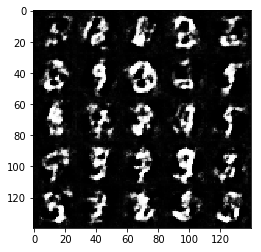

Epoch 1/2... Discriminator Loss: 0.7066... Generator Loss: 1.6387
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 1.8240
Epoch 1/2... Discriminator Loss: 0.6996... Generator Loss: 2.2644
Epoch 1/2... Discriminator Loss: 0.8488... Generator Loss: 1.7490
Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 2.2760
Epoch 1/2... Discriminator Loss: 0.8477... Generator Loss: 1.2216
Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 0.7596... Generator Loss: 1.3218
Epoch 1/2... Discriminator Loss: 1.0228... Generator Loss: 2.2140
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 0.5740


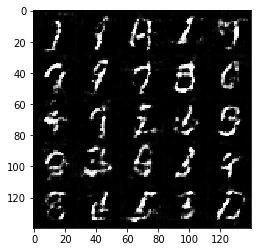

Epoch 1/2... Discriminator Loss: 0.7924... Generator Loss: 1.5887
Epoch 1/2... Discriminator Loss: 0.7932... Generator Loss: 2.1611
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 1.7556
Epoch 1/2... Discriminator Loss: 1.1355... Generator Loss: 0.7160
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 1.1181
Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 2.6320
Epoch 1/2... Discriminator Loss: 0.9160... Generator Loss: 1.1657
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.6304
Epoch 1/2... Discriminator Loss: 0.8777... Generator Loss: 1.5422
Epoch 1/2... Discriminator Loss: 0.9499... Generator Loss: 0.9807


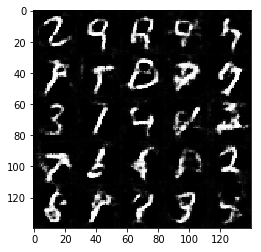

Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 0.5485
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 1.7007
Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 1.5604
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.3482
Epoch 1/2... Discriminator Loss: 0.8412... Generator Loss: 1.1832
Epoch 1/2... Discriminator Loss: 1.5007... Generator Loss: 0.5078
Epoch 1/2... Discriminator Loss: 1.3206... Generator Loss: 0.6044
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 0.8835
Epoch 1/2... Discriminator Loss: 1.0798... Generator Loss: 0.7793
Epoch 1/2... Discriminator Loss: 0.9035... Generator Loss: 1.6342


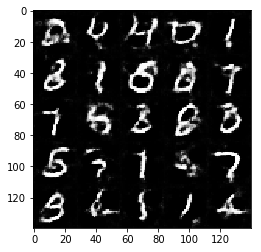

Epoch 1/2... Discriminator Loss: 0.9175... Generator Loss: 1.5484
Epoch 1/2... Discriminator Loss: 0.8853... Generator Loss: 1.9131
Epoch 1/2... Discriminator Loss: 0.9767... Generator Loss: 1.1733
Epoch 1/2... Discriminator Loss: 0.7676... Generator Loss: 1.3912
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 1.7572
Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 1.1265
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 1.4829
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.4976
Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 1.1374
Epoch 1/2... Discriminator Loss: 1.0950... Generator Loss: 0.9457


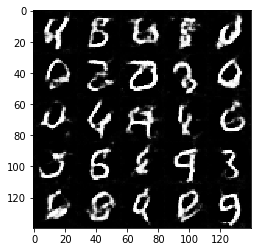

Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 1.1004
Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 1.2162
Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 2.0189
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 1.2451
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 0.9164
Epoch 1/2... Discriminator Loss: 0.9403... Generator Loss: 0.9737
Epoch 1/2... Discriminator Loss: 0.8973... Generator Loss: 1.1977
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 0.9934... Generator Loss: 1.3270
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 0.7016


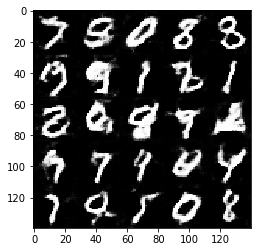

Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 1.1226
Epoch 1/2... Discriminator Loss: 0.9277... Generator Loss: 1.0491
Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 1.9447
Epoch 1/2... Discriminator Loss: 0.7345... Generator Loss: 1.3675
Epoch 1/2... Discriminator Loss: 0.7160... Generator Loss: 1.7416
Epoch 1/2... Discriminator Loss: 1.7579... Generator Loss: 0.4410
Epoch 1/2... Discriminator Loss: 1.0909... Generator Loss: 1.3080
Epoch 1/2... Discriminator Loss: 1.0076... Generator Loss: 0.8383
Epoch 1/2... Discriminator Loss: 0.8398... Generator Loss: 1.4846
Epoch 1/2... Discriminator Loss: 0.8601... Generator Loss: 1.6092


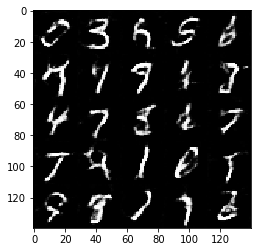

Epoch 1/2... Discriminator Loss: 1.5096... Generator Loss: 0.5091
Epoch 1/2... Discriminator Loss: 0.6972... Generator Loss: 1.5744
Epoch 1/2... Discriminator Loss: 0.9756... Generator Loss: 1.0606
Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 1.0896
Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 1.8482
Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.2323
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 1.5742
Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 1.1301
Epoch 2/2... Discriminator Loss: 0.8651... Generator Loss: 1.3955
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.6781


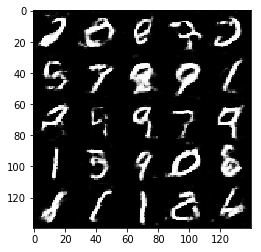

Epoch 2/2... Discriminator Loss: 0.8909... Generator Loss: 1.1905
Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 1.3875
Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 1.0796
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 1.0428
Epoch 2/2... Discriminator Loss: 0.7393... Generator Loss: 1.7648
Epoch 2/2... Discriminator Loss: 0.8992... Generator Loss: 1.0642
Epoch 2/2... Discriminator Loss: 1.6667... Generator Loss: 0.4320
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 0.8090
Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 1.3432
Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 0.9596


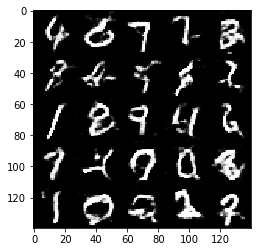

Epoch 2/2... Discriminator Loss: 0.7114... Generator Loss: 1.5287
Epoch 2/2... Discriminator Loss: 0.7514... Generator Loss: 1.7156
Epoch 2/2... Discriminator Loss: 0.6913... Generator Loss: 1.5938
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 1.5248
Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 1.2703
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 1.3326
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 1.2024
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 0.9093
Epoch 2/2... Discriminator Loss: 2.5401... Generator Loss: 0.1776
Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 1.3515


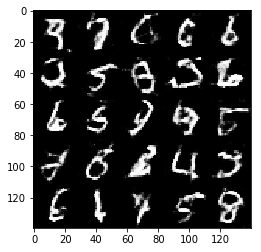

Epoch 2/2... Discriminator Loss: 0.7372... Generator Loss: 1.8074
Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 1.1596
Epoch 2/2... Discriminator Loss: 0.7334... Generator Loss: 1.4965
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.2666
Epoch 2/2... Discriminator Loss: 0.8028... Generator Loss: 1.5574
Epoch 2/2... Discriminator Loss: 0.7582... Generator Loss: 1.6415
Epoch 2/2... Discriminator Loss: 1.0491... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 0.6584
Epoch 2/2... Discriminator Loss: 0.7932... Generator Loss: 1.6205
Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 2.4878


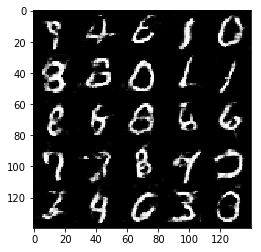

Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 1.2559
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 1.1565
Epoch 2/2... Discriminator Loss: 0.7932... Generator Loss: 1.4195
Epoch 2/2... Discriminator Loss: 0.7926... Generator Loss: 1.2879
Epoch 2/2... Discriminator Loss: 2.4518... Generator Loss: 0.2348
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 0.7978... Generator Loss: 1.5332
Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 1.3111
Epoch 2/2... Discriminator Loss: 0.7477... Generator Loss: 1.4163
Epoch 2/2... Discriminator Loss: 4.3013... Generator Loss: 5.2893


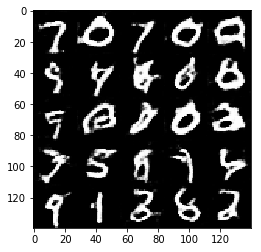

Epoch 2/2... Discriminator Loss: 1.1464... Generator Loss: 0.8327
Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 1.2417
Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 0.7365
Epoch 2/2... Discriminator Loss: 0.7290... Generator Loss: 1.6283
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 1.0564
Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 1.1736
Epoch 2/2... Discriminator Loss: 0.8580... Generator Loss: 1.0831
Epoch 2/2... Discriminator Loss: 0.9668... Generator Loss: 0.9909
Epoch 2/2... Discriminator Loss: 1.1427... Generator Loss: 0.7383
Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 1.7743


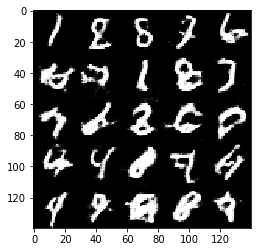

Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 1.0103
Epoch 2/2... Discriminator Loss: 0.7936... Generator Loss: 1.3306
Epoch 2/2... Discriminator Loss: 0.7919... Generator Loss: 1.3493
Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 1.4033
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 1.2046
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 2.1870
Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 0.7019
Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 1.1953
Epoch 2/2... Discriminator Loss: 1.0289... Generator Loss: 0.9705
Epoch 2/2... Discriminator Loss: 0.7483... Generator Loss: 1.4278


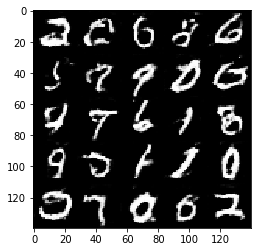

Epoch 2/2... Discriminator Loss: 0.8524... Generator Loss: 1.2669
Epoch 2/2... Discriminator Loss: 0.9984... Generator Loss: 2.3730
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.1893
Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 0.9664
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 0.7239
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 1.1836
Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 1.3378
Epoch 2/2... Discriminator Loss: 0.9254... Generator Loss: 1.9136
Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 1.0565
Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 0.7327


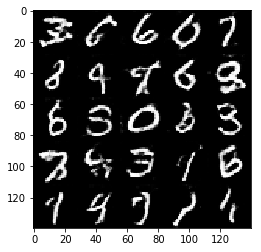

Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.3095
Epoch 2/2... Discriminator Loss: 0.9343... Generator Loss: 0.9704
Epoch 2/2... Discriminator Loss: 1.1336... Generator Loss: 0.9642
Epoch 2/2... Discriminator Loss: 0.8959... Generator Loss: 1.6916
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 1.8274
Epoch 2/2... Discriminator Loss: 0.8773... Generator Loss: 1.0825
Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 1.6755
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 0.6046... Generator Loss: 1.7031
Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 0.6938


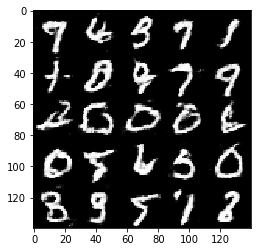

Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 1.0884
Epoch 2/2... Discriminator Loss: 1.5011... Generator Loss: 0.5324
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.1934
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.6020
Epoch 2/2... Discriminator Loss: 0.7394... Generator Loss: 1.6510
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 1.6162
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 1.3567


In [85]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.6066... Generator Loss: 0.0534
Epoch 1/1... Discriminator Loss: 1.7925... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 1.5963... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 2.9786... Generator Loss: 4.4024
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 1.6339
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.8002
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 1.7430
Epoch 1/1... Discriminator Loss: 2.3369... Generator Loss: 0.2017
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 3.1076
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.6665


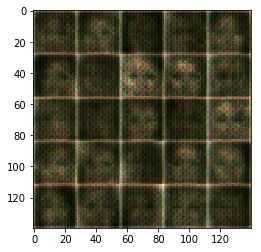

Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 2.3366
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 2.8334
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 2.7104
Epoch 1/1... Discriminator Loss: 2.0784... Generator Loss: 3.3848
Epoch 1/1... Discriminator Loss: 1.7819... Generator Loss: 3.5308
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 1.9310... Generator Loss: 2.3333
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 3.0611
Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 1.1241


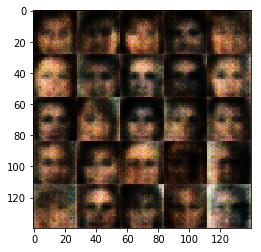

Epoch 1/1... Discriminator Loss: 2.0344... Generator Loss: 0.3148
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 1.4799
Epoch 1/1... Discriminator Loss: 1.7824... Generator Loss: 0.3109
Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 2.8032
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.8125... Generator Loss: 0.3046
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 1.8138... Generator Loss: 0.3078
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.4733


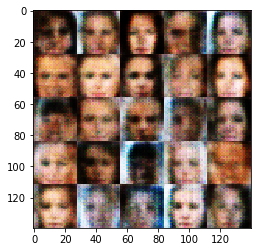

Epoch 1/1... Discriminator Loss: 1.7650... Generator Loss: 0.3193
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 1.4694
Epoch 1/1... Discriminator Loss: 0.7135... Generator Loss: 3.2176
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 3.3312
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.4013
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.4475
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 4.4746


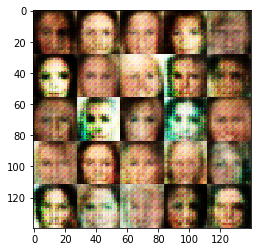

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 2.0388
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 2.0684... Generator Loss: 0.2613
Epoch 1/1... Discriminator Loss: 1.8254... Generator Loss: 0.3293
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 2.1415
Epoch 1/1... Discriminator Loss: 2.5069... Generator Loss: 0.1393
Epoch 1/1... Discriminator Loss: 1.5832... Generator Loss: 0.4261
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.7586


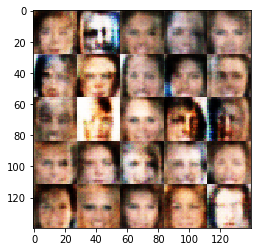

Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 2.0890
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 2.4732
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.4401
Epoch 1/1... Discriminator Loss: 1.5933... Generator Loss: 2.0102
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.4260
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.4299
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 3.4428
Epoch 1/1... Discriminator Loss: 2.2820... Generator Loss: 0.1883


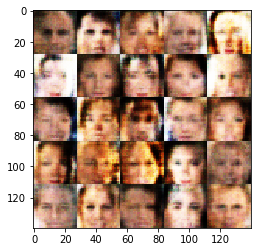

Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 3.0907
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 4.0132
Epoch 1/1... Discriminator Loss: 1.9631... Generator Loss: 0.2607
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.7332... Generator Loss: 0.3973
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 4.3469
Epoch 1/1... Discriminator Loss: 1.7873... Generator Loss: 0.3043
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 2.2284
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.5091


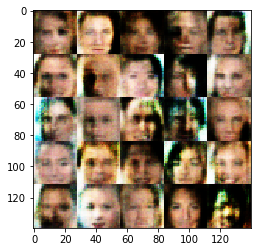

Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 4.3335
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 3.8967
Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 1.4752
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 1.8973
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.6975


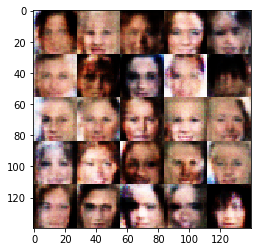

Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 3.8058
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.9367
Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 3.1113
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 0.5403... Generator Loss: 1.9659
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.3382
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 0.4473... Generator Loss: 2.6552
Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 2.4821


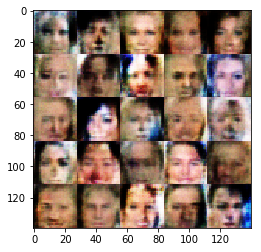

Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 2.4120
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 1.7209
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 2.0842
Epoch 1/1... Discriminator Loss: 0.6281... Generator Loss: 2.0852
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 2.2528... Generator Loss: 0.2008
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 3.8621
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 2.5666
Epoch 1/1... Discriminator Loss: 0.5488... Generator Loss: 1.8266


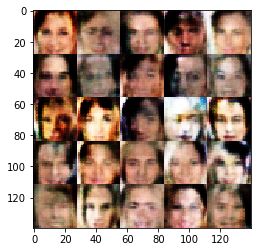

Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 1.8700
Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 3.5968
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 1.8694
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 3.0257
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 4.4171
Epoch 1/1... Discriminator Loss: 2.9107... Generator Loss: 3.8722
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 2.7801
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 2.2224
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 1.6404
Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 2.2501


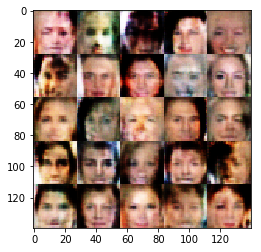

Epoch 1/1... Discriminator Loss: 0.5394... Generator Loss: 3.1027
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 4.6975
Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 2.9136
Epoch 1/1... Discriminator Loss: 1.9998... Generator Loss: 0.2539
Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 1.5177
Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 3.1163
Epoch 1/1... Discriminator Loss: 0.4293... Generator Loss: 2.8072
Epoch 1/1... Discriminator Loss: 0.4270... Generator Loss: 2.8706
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 5.0672
Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 2.7121


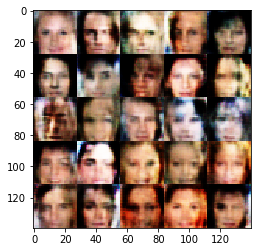

Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 1.6784
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 2.1458
Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 3.2161
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 4.3290
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 2.8831
Epoch 1/1... Discriminator Loss: 0.4264... Generator Loss: 2.6686
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 1.9413
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 1.3956
Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 2.8570
Epoch 1/1... Discriminator Loss: 0.4369... Generator Loss: 3.0294


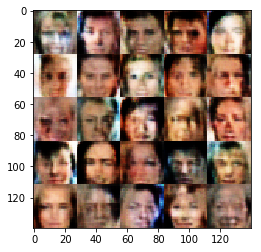

Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 3.1950
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.4216
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 1.8223
Epoch 1/1... Discriminator Loss: 0.5471... Generator Loss: 2.1312
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 0.4706... Generator Loss: 2.6928
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.1060
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 3.9373
Epoch 1/1... Discriminator Loss: 0.4706... Generator Loss: 2.2402
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.3418


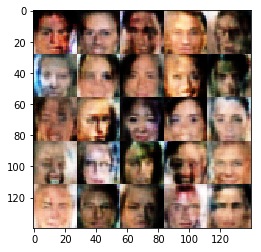

Epoch 1/1... Discriminator Loss: 0.4516... Generator Loss: 2.3035
Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 2.1452
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 1.9385
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 3.4480
Epoch 1/1... Discriminator Loss: 1.8872... Generator Loss: 4.2753
Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 3.8589
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 2.9275
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 4.1402
Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 4.0195
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.7118


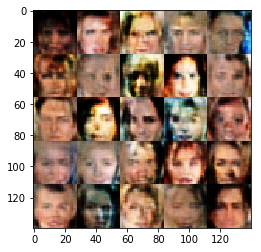

Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 2.4786
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 3.0412
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 0.6392... Generator Loss: 1.5523
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 1.9672
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 0.4064... Generator Loss: 3.5092
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 1.6791
Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 1.5925


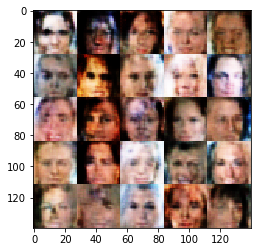

Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 0.4831... Generator Loss: 2.2349
Epoch 1/1... Discriminator Loss: 0.4183... Generator Loss: 3.1052
Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 2.3884
Epoch 1/1... Discriminator Loss: 2.1712... Generator Loss: 3.2814
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 2.6891
Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 1.7897
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 2.1336
Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 2.7747
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 2.3301


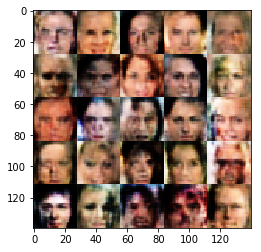

Epoch 1/1... Discriminator Loss: 0.6617... Generator Loss: 2.2506
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 4.3254
Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 4.3814
Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 3.7843
Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 2.8865
Epoch 1/1... Discriminator Loss: 1.7468... Generator Loss: 0.3647
Epoch 1/1... Discriminator Loss: 0.4449... Generator Loss: 2.7033
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 3.0982
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 2.5645
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 2.3568


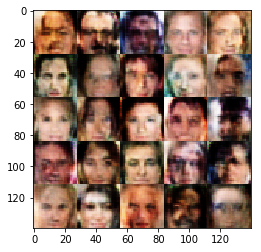

Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 1.9750
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 1.4503
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 3.3566
Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 3.0191
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 1.7775
Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 2.1538
Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 3.2817
Epoch 1/1... Discriminator Loss: 2.4994... Generator Loss: 0.1789
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.3744


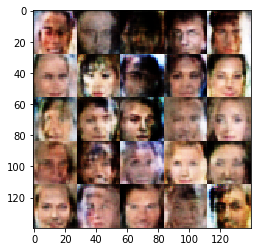

Epoch 1/1... Discriminator Loss: 0.5689... Generator Loss: 3.0773
Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 1.2737
Epoch 1/1... Discriminator Loss: 0.5131... Generator Loss: 3.1355
Epoch 1/1... Discriminator Loss: 1.7822... Generator Loss: 2.4083
Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 2.2048
Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 2.3750
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 3.1934
Epoch 1/1... Discriminator Loss: 0.6545... Generator Loss: 1.4339
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 1.7466
Epoch 1/1... Discriminator Loss: 1.9965... Generator Loss: 4.7953


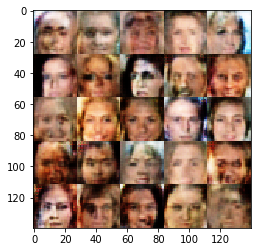

Epoch 1/1... Discriminator Loss: 0.7444... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 2.2108
Epoch 1/1... Discriminator Loss: 0.4683... Generator Loss: 2.2526
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 2.5801
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.1746
Epoch 1/1... Discriminator Loss: 0.5091... Generator Loss: 2.3382
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 1.2565
Epoch 1/1... Discriminator Loss: 2.2624... Generator Loss: 0.2040
Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 2.6201


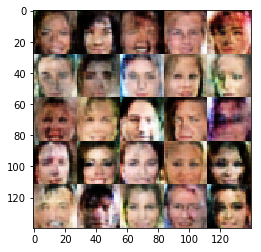

Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 1.6868
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 2.7690
Epoch 1/1... Discriminator Loss: 0.4725... Generator Loss: 2.3770
Epoch 1/1... Discriminator Loss: 3.3060... Generator Loss: 4.3241
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 3.5956... Generator Loss: 4.7938
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 3.4291
Epoch 1/1... Discriminator Loss: 0.6291... Generator Loss: 1.5538


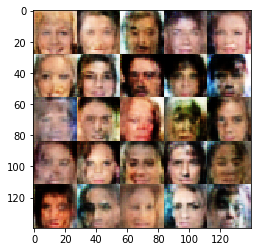

Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 2.4821
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 2.2010
Epoch 1/1... Discriminator Loss: 0.5502... Generator Loss: 2.1168
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 2.6270... Generator Loss: 0.1340
Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 1.8767
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 2.3429
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.4436


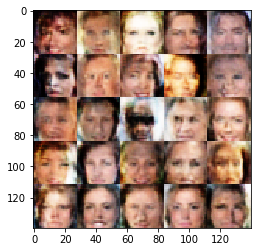

Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.6893
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 2.8378
Epoch 1/1... Discriminator Loss: 0.5360... Generator Loss: 1.8782
Epoch 1/1... Discriminator Loss: 0.5715... Generator Loss: 3.5526
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.5459
Epoch 1/1... Discriminator Loss: 1.6662... Generator Loss: 3.4001
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 2.0685
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 1.3901
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 1.7020


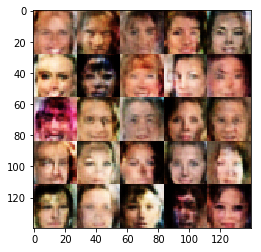

Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.6008... Generator Loss: 2.7498
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.2345
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.9269
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 2.3796
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 3.8547
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.5733


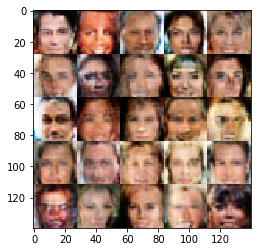

Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 2.5845
Epoch 1/1... Discriminator Loss: 1.8518... Generator Loss: 2.3558
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 2.8349
Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 1.9702
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 0.4120... Generator Loss: 2.8215
Epoch 1/1... Discriminator Loss: 2.0647... Generator Loss: 3.4009


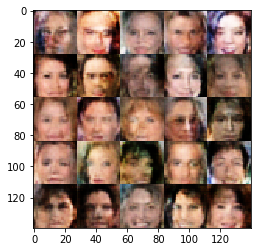

Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 2.1091
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.7544
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 1.7559
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 2.9180
Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 3.1023
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 3.5472
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 2.4340
Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 1.6017
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 2.4692


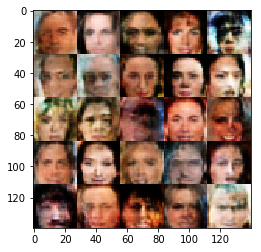

Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 3.5997
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 2.0028
Epoch 1/1... Discriminator Loss: 0.5107... Generator Loss: 3.2213
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 2.7323
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.0554
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 2.7082
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 2.3048
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 1.5027
Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 2.1916


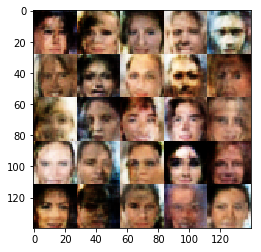

Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.5796
Epoch 1/1... Discriminator Loss: 2.0019... Generator Loss: 2.9691
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 2.5392
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 1.3638
Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 3.7635
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 2.8301
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.1193
Epoch 1/1... Discriminator Loss: 0.5891... Generator Loss: 2.9643
Epoch 1/1... Discriminator Loss: 1.9739... Generator Loss: 0.2624


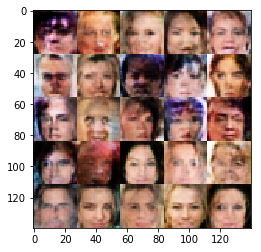

Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 3.6863
Epoch 1/1... Discriminator Loss: 1.8721... Generator Loss: 0.3014
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 0.4091... Generator Loss: 2.7595
Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 1.2115
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 1.8074
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 2.0061
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 2.0907
Epoch 1/1... Discriminator Loss: 0.5284... Generator Loss: 2.3456


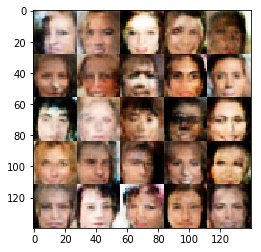

Epoch 1/1... Discriminator Loss: 1.6583... Generator Loss: 0.3627
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 3.4707
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 2.0233
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.7665
Epoch 1/1... Discriminator Loss: 0.4588... Generator Loss: 2.4598
Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 2.2635
Epoch 1/1... Discriminator Loss: 1.7438... Generator Loss: 2.7629
Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 2.3578
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.1689
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.9361


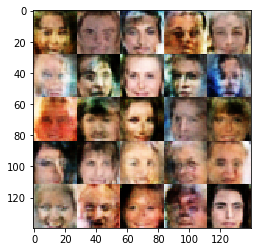

Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 1.7490
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 2.0776
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 2.3453
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 2.5103
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 2.8852
Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 1.8474
Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 2.7934
Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 1.8071
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.2594


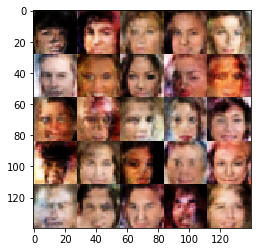

Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 1.7419
Epoch 1/1... Discriminator Loss: 1.7956... Generator Loss: 0.3341
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 2.1477
Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 1.3477
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 4.8803
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.7712
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 2.3220
Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 2.4636
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 2.6061


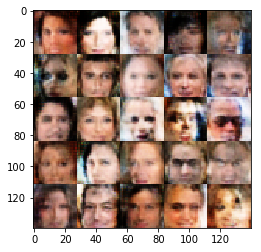

Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 2.3624
Epoch 1/1... Discriminator Loss: 0.6372... Generator Loss: 2.1512
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 1.7564
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 1.3419
Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 2.0453
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.4587
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 2.4406
Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 2.5069
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.4176


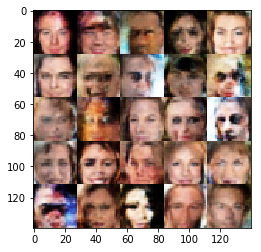

Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 2.2636
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 3.2419
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 1.5921
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 2.4601
Epoch 1/1... Discriminator Loss: 1.9686... Generator Loss: 3.0536
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 1.9246
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 2.1074
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.7641


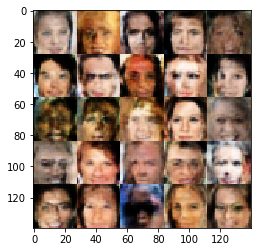

Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 1.9643
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 1.8213
Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 2.7278
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 2.2233
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.8145
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 2.3963
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.5728
Epoch 1/1... Discriminator Loss: 0.5932... Generator Loss: 1.5783
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.0323
Epoch 1/1... Discriminator Loss: 2.0488... Generator Loss: 3.0483


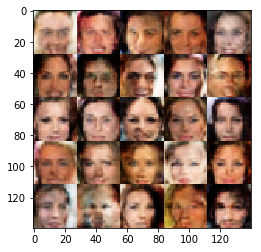

Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 1.6102
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 0.4135... Generator Loss: 3.1351
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.9031
Epoch 1/1... Discriminator Loss: 0.7504... Generator Loss: 2.2904
Epoch 1/1... Discriminator Loss: 0.4854... Generator Loss: 2.2314
Epoch 1/1... Discriminator Loss: 0.5378... Generator Loss: 2.5739
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 3.1999
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 3.0526


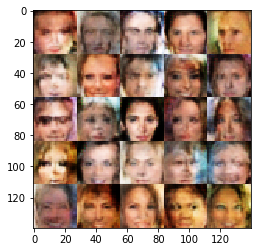

Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.2959
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 1.7192
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 2.0188
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 2.1605
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.3939
Epoch 1/1... Discriminator Loss: 0.4291... Generator Loss: 2.6843
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 3.0660
Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 1.7508


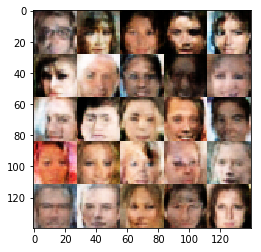

Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 3.0968
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 4.0330
Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 2.3882
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 2.3322
Epoch 1/1... Discriminator Loss: 0.4858... Generator Loss: 2.2335
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 0.4780... Generator Loss: 2.5650
Epoch 1/1... Discriminator Loss: 1.8183... Generator Loss: 0.3155
Epoch 1/1... Discriminator Loss: 0.6236... Generator Loss: 1.6739
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 1.7003


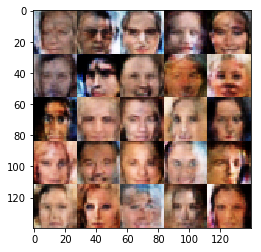

Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.4589
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 1.5618
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 1.9382
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 2.5595
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 3.1735
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 3.0841
Epoch 1/1... Discriminator Loss: 2.2926... Generator Loss: 0.1928
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 3.0955
Epoch 1/1... Discriminator Loss: 1.7353... Generator Loss: 0.3539


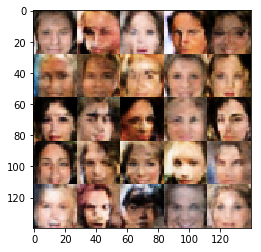

Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.8849
Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 2.2436
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 1.7393
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 0.6184... Generator Loss: 1.5839
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 2.9365
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.2065
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 2.5813
Epoch 1/1... Discriminator Loss: 1.8083... Generator Loss: 0.3932


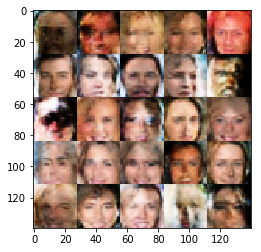

Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 2.7563
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 2.8339
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 2.3559
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 2.8192
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 1.8042
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 3.3824
Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 3.0667
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 2.2116


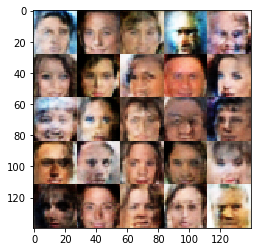

Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 3.2859
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 5.0412
Epoch 1/1... Discriminator Loss: 2.8224... Generator Loss: 3.6977
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 2.8342
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 2.4974
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 2.6109
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 2.4147
Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 2.7977
Epoch 1/1... Discriminator Loss: 0.5916... Generator Loss: 2.7488


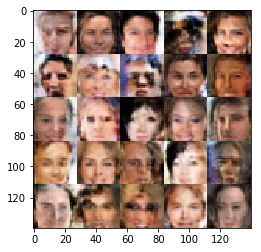

Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 3.0171
Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 2.1239
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 0.5631... Generator Loss: 1.7025
Epoch 1/1... Discriminator Loss: 1.9938... Generator Loss: 0.2793
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 2.2846
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.5283
Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 0.5431... Generator Loss: 1.8551


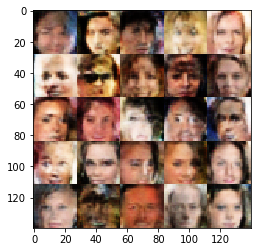

Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 2.6566
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 1.9286
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 2.8387
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 1.3780
Epoch 1/1... Discriminator Loss: 1.9176... Generator Loss: 0.3023
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 1.1192


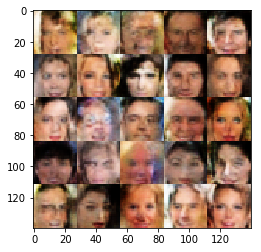

Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 0.4270... Generator Loss: 2.6740
Epoch 1/1... Discriminator Loss: 0.5188... Generator Loss: 2.7562
Epoch 1/1... Discriminator Loss: 1.7536... Generator Loss: 0.3326
Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 2.7498
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 1.6831
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 2.4345
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.4744
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 2.6502
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 3.0743


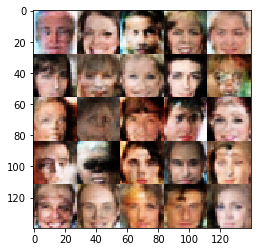

Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 3.9487
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 3.1997
Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 2.5959
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 2.0440
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 2.2128
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 2.5270
Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 3.4629


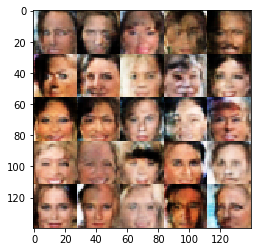

Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 2.4321
Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 3.4973
Epoch 1/1... Discriminator Loss: 0.3669... Generator Loss: 4.1444
Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 2.1271
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 2.9326
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 2.1628
Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 2.3311
Epoch 1/1... Discriminator Loss: 0.4570... Generator Loss: 2.8111
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.0113


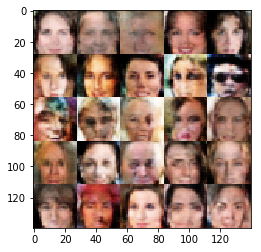

Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 1.2523
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 3.2683
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 1.7937
Epoch 1/1... Discriminator Loss: 0.6960... Generator Loss: 1.8738
Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 3.4488
Epoch 1/1... Discriminator Loss: 0.3814... Generator Loss: 3.3036
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 3.4699
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 2.0904
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 2.5368


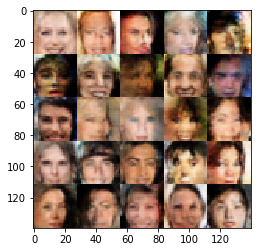

Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 2.0797
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 4.0770
Epoch 1/1... Discriminator Loss: 0.4395... Generator Loss: 2.7409
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 4.0676
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 2.1332
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.1156
Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 2.0699


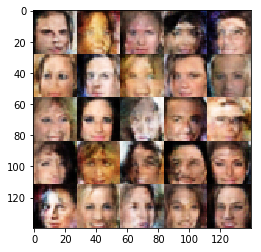

Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 3.0519
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 2.2873
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 2.6785
Epoch 1/1... Discriminator Loss: 0.5792... Generator Loss: 1.7060
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 2.2236
Epoch 1/1... Discriminator Loss: 0.4259... Generator Loss: 2.6977
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 2.0377
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.5462


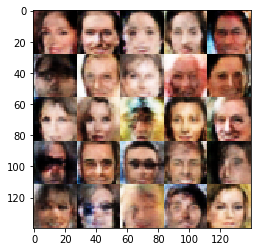

Epoch 1/1... Discriminator Loss: 0.5745... Generator Loss: 1.6418
Epoch 1/1... Discriminator Loss: 0.5943... Generator Loss: 2.2892
Epoch 1/1... Discriminator Loss: 0.5051... Generator Loss: 2.2790
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 0.4934... Generator Loss: 2.1809
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 3.2073
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 1.8094
Epoch 1/1... Discriminator Loss: 1.9852... Generator Loss: 3.3962
Epoch 1/1... Discriminator Loss: 0.5253... Generator Loss: 2.5262
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 2.7436


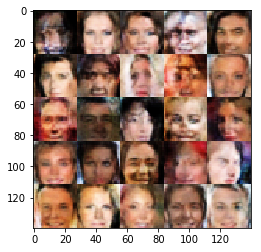

Epoch 1/1... Discriminator Loss: 0.5503... Generator Loss: 2.5641
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 2.0868
Epoch 1/1... Discriminator Loss: 3.2606... Generator Loss: 0.0916
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 2.2197
Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 2.6638
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 1.5838
Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 2.7237
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 3.0363


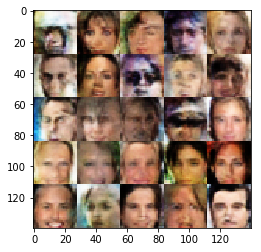

Epoch 1/1... Discriminator Loss: 1.7441... Generator Loss: 0.3334
Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 2.0274
Epoch 1/1... Discriminator Loss: 1.7798... Generator Loss: 0.3299
Epoch 1/1... Discriminator Loss: 0.4417... Generator Loss: 2.5071
Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 1.9431
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 4.2229
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 2.3366
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 0.3606... Generator Loss: 4.1126


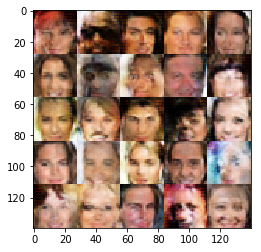

Epoch 1/1... Discriminator Loss: 1.6315... Generator Loss: 0.4125
Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 1.3582
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.4988
Epoch 1/1... Discriminator Loss: 0.6450... Generator Loss: 1.4913
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 1.8240
Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 1.7684
Epoch 1/1... Discriminator Loss: 0.6743... Generator Loss: 1.4165
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 1.3881
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 2.1907


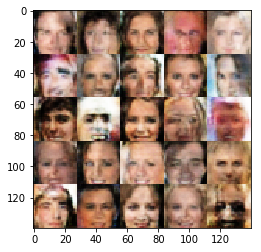

Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 3.2572
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 1.9380
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 1.9346
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 2.5109
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 3.5974
Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 2.4005
Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 4.1340
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 3.0213
Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 3.4332


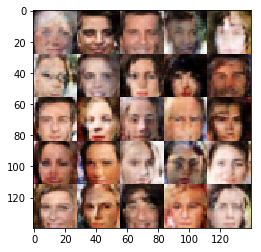

Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.9557... Generator Loss: 2.8292
Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 3.3050
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 1.3488
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 2.0163
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 2.2995
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 1.5292
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 3.1811


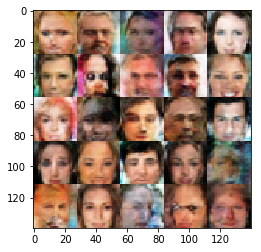

Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.3864
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 3.8687
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 2.3942
Epoch 1/1... Discriminator Loss: 0.7132... Generator Loss: 1.2947
Epoch 1/1... Discriminator Loss: 2.1210... Generator Loss: 2.8539
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 2.2825
Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 1.9356
Epoch 1/1... Discriminator Loss: 0.5970... Generator Loss: 3.1737
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.5505


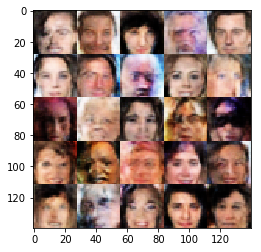

Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 2.8640
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 2.0014
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 1.9053
Epoch 1/1... Discriminator Loss: 0.5402... Generator Loss: 2.0139
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 3.4646
Epoch 1/1... Discriminator Loss: 0.4327... Generator Loss: 3.0149
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 3.3810
Epoch 1/1... Discriminator Loss: 0.6505... Generator Loss: 1.4424


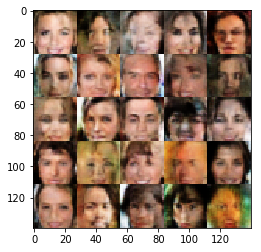

Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 3.1992
Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 4.1426
Epoch 1/1... Discriminator Loss: 0.4809... Generator Loss: 2.1581
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 3.2601
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 2.0218... Generator Loss: 0.2816
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.4397
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 0.4246... Generator Loss: 3.0002


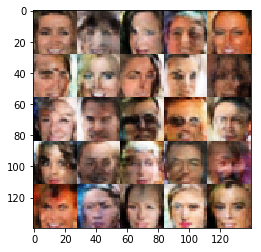

Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 2.0207
Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 1.5601
Epoch 1/1... Discriminator Loss: 0.4927... Generator Loss: 2.1483
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 2.5724
Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 2.3672
Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 3.7045


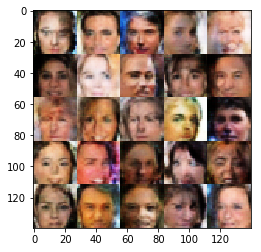

Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 1.6419
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 2.3168
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 2.3925
Epoch 1/1... Discriminator Loss: 0.5390... Generator Loss: 1.9794
Epoch 1/1... Discriminator Loss: 0.4125... Generator Loss: 2.7351
Epoch 1/1... Discriminator Loss: 2.3160... Generator Loss: 0.2077
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 1.9853
Epoch 1/1... Discriminator Loss: 0.4526... Generator Loss: 2.6192
Epoch 1/1... Discriminator Loss: 0.5164... Generator Loss: 2.0362
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 3.7418


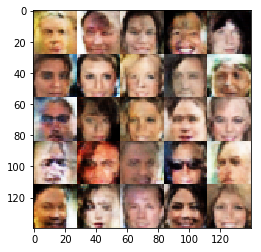

Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 2.1085
Epoch 1/1... Discriminator Loss: 0.4200... Generator Loss: 2.7557
Epoch 1/1... Discriminator Loss: 0.4125... Generator Loss: 2.7361
Epoch 1/1... Discriminator Loss: 2.2183... Generator Loss: 4.2409
Epoch 1/1... Discriminator Loss: 0.4326... Generator Loss: 2.6783
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 1.6362
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 0.4351... Generator Loss: 2.6224
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 2.0976


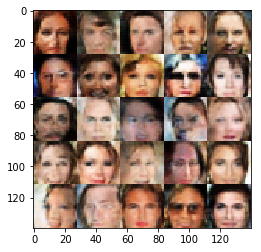

Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 2.2998
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 1.7399
Epoch 1/1... Discriminator Loss: 0.4596... Generator Loss: 2.3252


In [87]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.